In [1]:
import os as os
path = r'/home/falco/Desktop/directory/Cattle_AMR_2/'
os.chdir(r'/home/falco/Desktop/directory/Cattle_AMR_2/')
data_path = r"/home/falco/Desktop/directory/Cattle_AMR_2/data/"
output_path = r"/home/falco/Desktop/directory/Cattle_AMR_2/outputs/"

import sklearn
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold ,cross_val_score, train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve
from pandas_ml import ConfusionMatrix
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.style as style

import pandas.api.types as pdtypes

from plotnine import *
from plydata import *

np.random.seed(1234)
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from functions import functions as f


style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1
dpi = 1000
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']+1
plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['figure.figsize'] = 8, 8
import warnings
warnings.filterwarnings('ignore')

/home/falco/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%%time
data, d = f.read_process_data(data_path=data_path)

reading datafile
fill missing values and correct some values
changing the column names
generating output variables
final R_factor output
1    213
0     30
Name: Penicillin, dtype: int64
1    213
0     30
Name: Ceftiofur, dtype: int64
0    204
1     39
Name: Tetracycline, dtype: int64
CPU times: user 541 ms, sys: 10.9 ms, total: 552 ms
Wall time: 549 ms


In [3]:
data.filter(like = 'R').head()

,MT_Results Individual_CowID,F_Salmonella PCR_Result,F_AMR_CowID,SR_FOX,SR_AZI,SR_CHL,SR_TET,SR_AXO,SR_AUG2,SR_CIP,...,R_commensal,R_commensal_n,Sal_AbR_n,Entero_AbR_n,Ecoli_AbR_n,R_factor,Sal_R,Ecoli_R,Entero_R,Commensal_R
0,4672,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[Nitrofuran antibacterial, Macrolides]",2,0,2,0,1,0,0,1,1
1,1099,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[Oxazolidinones, Tetracyclines, Macrolides, Am...",4,0,4,0,2,0,0,2,2
2,3786,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[Nitrofuran antibacterial, Tetracyclines, Amph...",3,0,3,0,2,0,0,2,2
3,3596,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[Nitrofuran antibacterial, Oxazolidinones, Mac...",4,0,4,0,2,0,0,2,2
4,4880,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[Tetracyclines, Streptogramin, Amphenicols, Ma...",6,0,6,0,2,0,0,2,2


# Model Predictors

In [4]:
herd_parameters = [
    'HerdSize', 
    'RollingHerdAvg', 
    'Holstein',
    'Jersey',
    'CullPctMonth',
    'CullTimesMonth',
    'MainCullReason',
    'PctCullBeef',
    'PctCullCondemned',
    'PctInject',
    'VetTreats',
    'ManagerTreats',
    'StaffTreats',
    'ResiduePrevent',
    'Chalk4Withdrawal',
    'Inventory',
    'SeparateUse',
    'CombinationUse',
    'TrackAntibioticDose',
    'TrackAntibioticRoute',
    'FamiliarELDU',
    'FreqELDU',
    'NoELDU',
    'NumberCulled',
    'SalmonellaVaccine'
]

In [5]:
cow_parameters = ['LowMilkCull',
                  'ReproCull',
                  'LameCull',
                  'MastitisCull',
                  'OtherCull',
                  'AMD',
                  'Ani-Inf',
                  'No-Treatment',
                  'Other',
                  'Tetracycline',
                  'Penicillin',
                  'Ceftiofur',
                  'Season'
]

In [6]:
categorical = ['CullTimesMonth',
               'PctCullCondemned',
               'PctInject',
               'FreqELDU',
               'Season'
               ]

In [7]:
features = cow_parameters+ herd_parameters
len(features)

38

In [8]:
data['R_factor'].value_counts()

1    107
2     75
0     61
Name: R_factor, dtype: int64

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


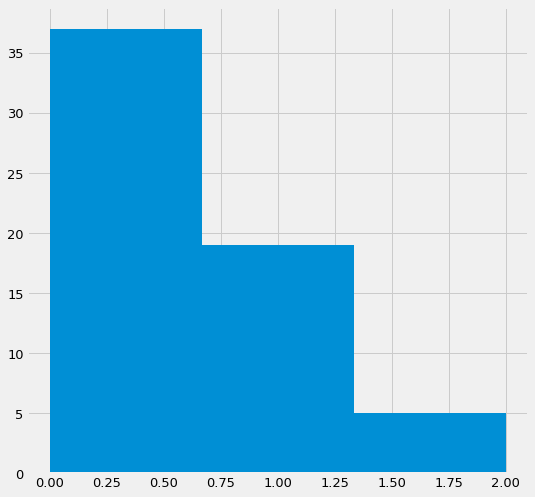

In [9]:
data_m = data[data['F_Salmonella PCR_Result'] == 'Positive']
plt.hist(data_m['Sal_R'], bins=3)
plt.show()

In [10]:
data_m['Sal_R'].value_counts()

0    37
1    19
2     5
Name: Sal_R, dtype: int64

## Model functions

In [11]:
from model_functions import *

In [12]:
from xgboost import XGBClassifier

In [13]:
parameters = {
    "learning_rate":[0.001, 0.002, 0.005, 0.008, 0.01, 0.02, 0.05, 0.10, 0.25, 0.5],
    "max_depth": [3,4,7, 8,9, 10,15, 20],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.4, 0.45, 0.5, 0.6, 0.7],
    "colsample_bytree": [0.2, 0.1,0.15, 0.4, 0.7],
    "objective":['multi:softprob'],
    "n_estimators":[3, 5, 10, 30, 40, 50, 100]
}

## XgBoost

## All bacteria


    
    Testing and Training datasets and preprocessing
    
    
(170,)

    
    Simple cross validation with default parameters
    
    
[0.43103448 0.44642857 0.60714286]
              precision    recall  f1-score   support

           0       0.49      0.42      0.45        43
           1       0.49      0.60      0.54        75
           2       0.51      0.40      0.45        52

    accuracy                           0.49       170
   macro avg       0.50      0.47      0.48       170
weighted avg       0.50      0.49      0.49       170


    
    Plot shows internal validation of the random forest model with default parameters
    
    


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


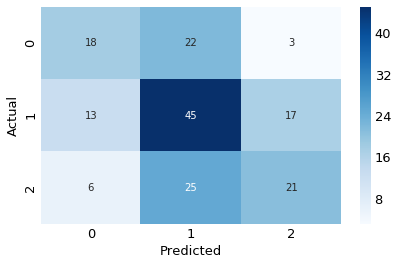


    
    Exrernal validation Multiple random forest model parameters are tested with k-fold cross validation (internal validation) method
    The cross validated model is then used on a "Holdout dataset" (data which is not seen by the model in cross validation)
    to understand its external validity.
    
    
    
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'colsample_bytree': 0.1, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 30, 'objective': 'multi:softprob'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



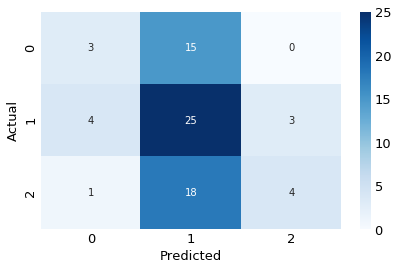

              precision    recall  f1-score   support

           0       0.38      0.17      0.23        18
           1       0.43      0.78      0.56        32
           2       0.57      0.17      0.27        23

    accuracy                           0.44        73
   macro avg       0.46      0.37      0.35        73
weighted avg       0.46      0.44      0.38        73



In [14]:
%%time 
gbc = XGBClassifier()
run_classifier(clf=gbc, k=3, 
               tuned_parameters=parameters,
               y='R_factor',
               cow_parameters= cow_parameters,
               herd_parameters = herd_parameters,  
               categorical=categorical, 
               data= data)

## Commensals


    
    Testing and Training datasets and preprocessing
    
    
(170,)

    
    Simple cross validation with default parameters
    
    
[0.57894737 0.42105263 0.5       ]
              precision    recall  f1-score   support

           0       0.49      0.50      0.49        46
           1       0.44      0.40      0.42        63
           2       0.56      0.61      0.58        61

    accuracy                           0.50       170
   macro avg       0.50      0.50      0.50       170
weighted avg       0.50      0.50      0.50       170


    
    Plot shows internal validation of the random forest model with default parameters
    
    


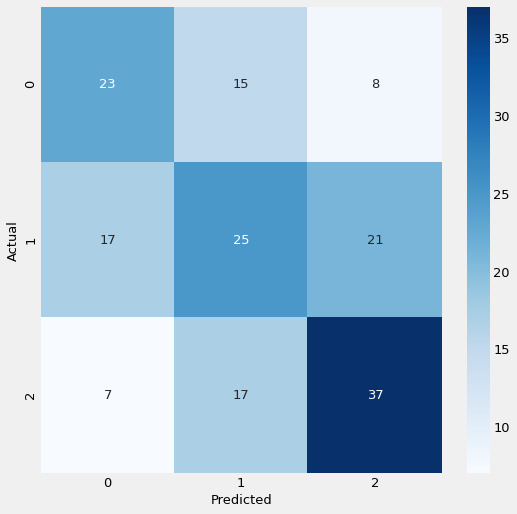


    
    Exrernal validation Multiple random forest model parameters are tested with k-fold cross validation (internal validation) method
    The cross validated model is then used on a "Holdout dataset" (data which is not seen by the model in cross validation)
    to understand its external validity.
    
    
    
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'colsample_bytree': 0.4, 'gamma': 0.6, 'learning_rate': 0.5, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 3, 'objective': 'multi:softprob'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



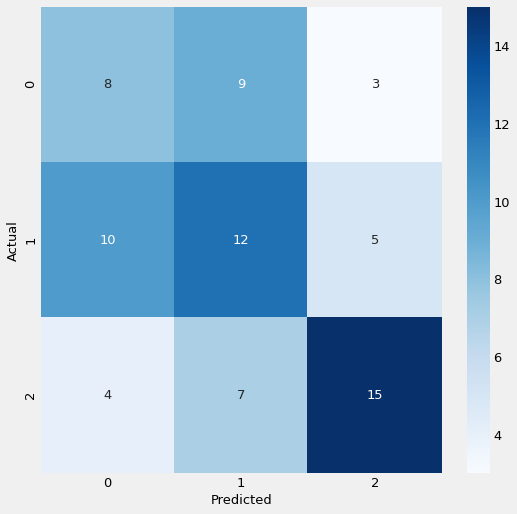

              precision    recall  f1-score   support

           0       0.36      0.40      0.38        20
           1       0.43      0.44      0.44        27
           2       0.65      0.58      0.61        26

    accuracy                           0.48        73
   macro avg       0.48      0.47      0.48        73
weighted avg       0.49      0.48      0.48        73

CPU times: user 1h 34min 36s, sys: 1.43 s, total: 1h 34min 38s
Wall time: 1h 34min 38s


In [14]:
%%time 
gbc = XGBClassifier()
run_classifier(clf=gbc, k=3, 
               tuned_parameters=parameters,
               y='Commensal_R',
               cow_parameters= cow_parameters,
               herd_parameters = herd_parameters,  
               categorical=categorical, 
               data= data)

## Ecoli


    
    Testing and Training datasets and preprocessing
    
    
(170,)

    
    Simple cross validation with default parameters
    
    
[0.70175439 0.52631579 0.64285714]
              precision    recall  f1-score   support

           0       0.69      0.81      0.75       113
           1       0.38      0.23      0.29        52
           2       0.40      0.40      0.40         5

    accuracy                           0.62       170
   macro avg       0.49      0.48      0.48       170
weighted avg       0.59      0.62      0.60       170


    
    Plot shows internal validation of the random forest model with default parameters
    
    


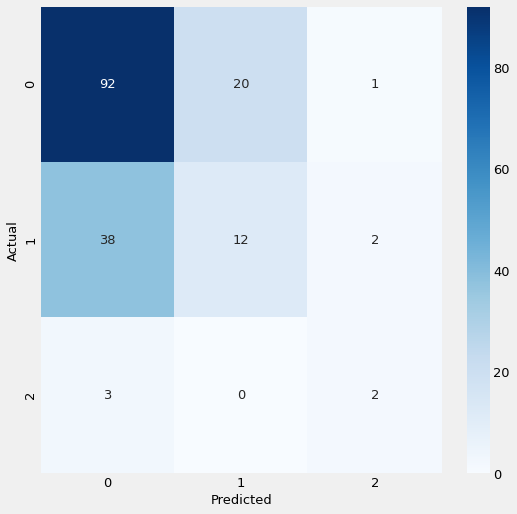


    
    Exrernal validation Multiple random forest model parameters are tested with k-fold cross validation (internal validation) method
    The cross validated model is then used on a "Holdout dataset" (data which is not seen by the model in cross validation)
    to understand its external validity.
    
    
    
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'colsample_bytree': 0.2, 'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 30, 'objective': 'multi:softprob'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



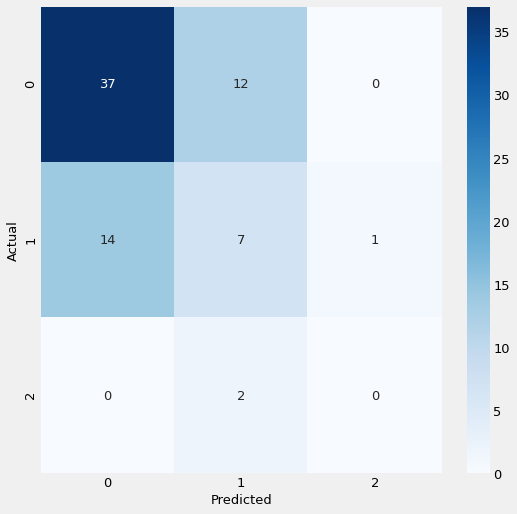

              precision    recall  f1-score   support

           0       0.73      0.76      0.74        49
           1       0.33      0.32      0.33        22
           2       0.00      0.00      0.00         2

    accuracy                           0.60        73
   macro avg       0.35      0.36      0.36        73
weighted avg       0.59      0.60      0.59        73

CPU times: user 1h 26min 17s, sys: 1.32 s, total: 1h 26min 19s
Wall time: 1h 26min 19s


In [15]:
%%time 
gbc = XGBClassifier()
run_classifier(clf=gbc, k=3, 
               tuned_parameters=parameters,
               y='Ecoli_R',
               cow_parameters= cow_parameters,
               herd_parameters = herd_parameters,  
               categorical=categorical, 
               data= data)

## Entercoccus


    
    Testing and Training datasets and preprocessing
    
    
(170,)

    
    Simple cross validation with default parameters
    
    
[0.49122807 0.52631579 0.44642857]
              precision    recall  f1-score   support

           0       0.49      0.45      0.47        60
           1       0.42      0.47      0.44        64
           2       0.59      0.57      0.58        46

    accuracy                           0.49       170
   macro avg       0.50      0.49      0.50       170
weighted avg       0.49      0.49      0.49       170


    
    Plot shows internal validation of the random forest model with default parameters
    
    


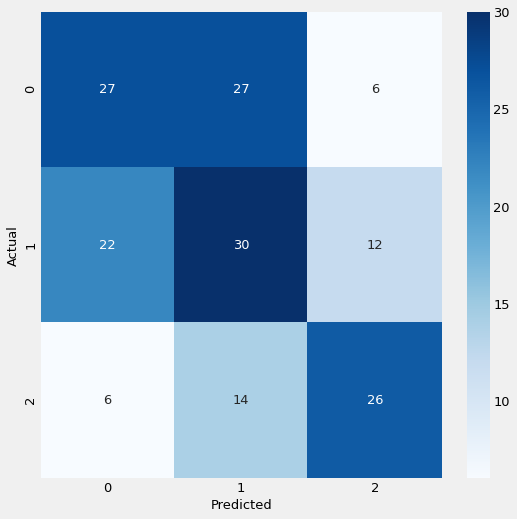


    
    Exrernal validation Multiple random forest model parameters are tested with k-fold cross validation (internal validation) method
    The cross validated model is then used on a "Holdout dataset" (data which is not seen by the model in cross validation)
    to understand its external validity.
    
    
    
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'colsample_bytree': 0.2, 'gamma': 0.2, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 10, 'objective': 'multi:softprob'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



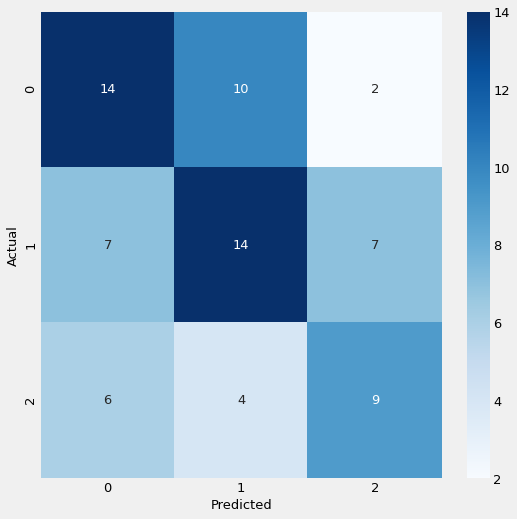

              precision    recall  f1-score   support

           0       0.52      0.54      0.53        26
           1       0.50      0.50      0.50        28
           2       0.50      0.47      0.49        19

    accuracy                           0.51        73
   macro avg       0.51      0.50      0.50        73
weighted avg       0.51      0.51      0.51        73

CPU times: user 1h 30min 24s, sys: 1.18 s, total: 1h 30min 25s
Wall time: 1h 30min 25s


In [16]:
%%time 
gbc = XGBClassifier()
run_classifier(clf=gbc, k=3, 
               tuned_parameters=parameters,
               y='Entero_R',
               cow_parameters= cow_parameters,
               herd_parameters = herd_parameters,  
               categorical=categorical, 
               data= data)

## Salmonella


    
    Testing and Training datasets and preprocessing
    
    
(42,)

    
    Simple cross validation with default parameters
    
    
[0.8        0.57142857 0.46153846]
              precision    recall  f1-score   support

           0       0.72      0.69      0.71        26
           1       0.47      0.62      0.53        13
           2       0.00      0.00      0.00         3

    accuracy                           0.62        42
   macro avg       0.40      0.44      0.41        42
weighted avg       0.59      0.62      0.60        42


    
    Plot shows internal validation of the random forest model with default parameters
    
    


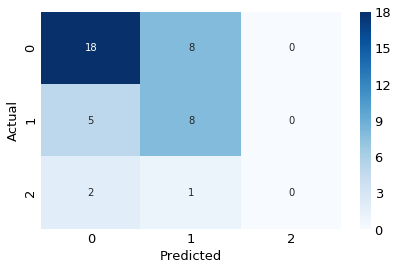


    
    Exrernal validation Multiple random forest model parameters are tested with k-fold cross validation (internal validation) method
    The cross validated model is then used on a "Holdout dataset" (data which is not seen by the model in cross validation)
    to understand its external validity.
    
    
    
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 5, 'objective': 'multi:softprob'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



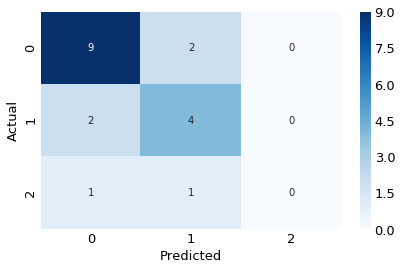

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.57      0.67      0.62         6
           2       0.00      0.00      0.00         2

    accuracy                           0.68        19
   macro avg       0.44      0.49      0.47        19
weighted avg       0.61      0.68      0.65        19

CPU times: user 48min 18s, sys: 908 ms, total: 48min 18s
Wall time: 48min 18s


In [15]:
%%time
""" 
Multi Drug resistance
"""
gbc = XGBClassifier()
run_classifier(clf=gbc, k=3, 
               tuned_parameters=parameters,
               y='Sal_R',
               cow_parameters= cow_parameters,
               herd_parameters = herd_parameters,  
               categorical=categorical, 
               data= data_m)